# Landsat Aquatic Reflectance <img align="right" src="../Supplementary_data/DE_Africa_Logo_Stacked_RGB_small.jpg">


* **Products used:** 
[landsat_c2l2_ar](https://explorer.digitalearth.africa/landsat_c2l2_ar),


## Background


## Description



***

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell.

### Load packages

In [1]:
import datacube

import numpy as np
import geopandas as gpd
from datacube.utils.geometry import Geometry
import matplotlib.pyplot as plt


from deafrica_tools.datahandling import load_ard
from deafrica_tools.plotting import rgb
from deafrica_tools.areaofinterest import define_area
from deafrica_tools.bandindices import calculate_indices

### Connect to the datacube

In [2]:
dc = datacube.Datacube(app="landsat_c2l2_ar")

### List measurements

We can further inspect the data available for each Landsat product using datacube's `list_measurements` functionality. The table below lists each of the measurements available in the data.

In [3]:
dc_measurements = dc.list_measurements()
dc_measurements.loc['landsat_c2l2_ar']

,name,dtype,units,nodata,aliases,flags_definition
measurement,,,,,,
RHORC_B1,RHORC_B1,int16,1,-9999.0,"[band_1, rh_coastal]",NaN
RHORC_B2,RHORC_B2,int16,1,-9999.0,"[band_2, rh_blue]",NaN
RHORC_B3,RHORC_B3,int16,1,-9999.0,"[band_3, rh_green]",NaN
RHORC_B4,RHORC_B4,int16,1,-9999.0,"[band_4, rh_red]",NaN
RHORC_B5,RHORC_B5,int16,1,-9999.0,"[band_5, rh_nir08]",NaN
RHORC_B6,RHORC_B6,int16,1,-9999.0,"[band_6, rh_swir16]",NaN
RHORC_B7,RHORC_B7,int16,1,-9999.0,"[band_7, rh_swir22]",NaN
AR_B1,AR_B1,int16,1,-9999.0,"[ar_band_1, coastal]",NaN
AR_B2,AR_B2,int16,1,-9999.0,"[ar_band_2, blue]",NaN


##### Load Landsat Collection 2 Level-2 Provisional Aquatic Reflectance


In [4]:
lat = 14.8376 
lon = -17.2279

# Time period
time = ("2020-02-07")

In [5]:
# Method 1: Specify the latitude, longitude, and buffer
aoi = define_area(lat=lat, lon=lon, buffer=0.021)

#Create a geopolygon and geodataframe of the area of interest
geopolygon = Geometry(aoi["features"][0]["geometry"], crs="epsg:4326")
geopolygon_gdf = gpd.GeoDataFrame(geometry=[geopolygon], crs=geopolygon.crs)

# Get the latitude and longitude range of the geopolygon
lat_range = (geopolygon_gdf.total_bounds[1], geopolygon_gdf.total_bounds[3])
lon_range = (geopolygon_gdf.total_bounds[0], geopolygon_gdf.total_bounds[2])

##### Load Aquatic Reflectance

In [6]:
# load data
ds_aq = dc.load(product="landsat_c2l2_ar",
             measurements=['red','blue','green','water'],
             output_crs='EPSG:6933',
             y = lat_range,
             x = lon_range,
             time=time,
             resolution=(-30, 30),
             group_by="solar_day",
            )

print(ds_aq)

<xarray.Dataset>
Dimensions:      (time: 1, y: 173, x: 136)
Coordinates:
  * time         (time) datetime64[ns] 2020-02-07T11:27:31.555658
  * y            (y) float64 1.875e+06 1.875e+06 1.875e+06 ... 1.87e+06 1.87e+06
  * x            (x) float64 -1.664e+06 -1.664e+06 ... -1.66e+06 -1.66e+06
    spatial_ref  int32 6933
Data variables:
    red          (time, y, x) int16 -9999 -9999 -9999 ... -9999 -9999 -9999
    blue         (time, y, x) int16 -9999 -9999 -9999 ... -9999 -9999 -9999
    green        (time, y, x) int16 -9999 -9999 -9999 ... -9999 -9999 -9999
    water        (time, y, x) uint8 3 3 3 3 3 3 3 3 3 3 ... 0 0 0 0 0 0 0 0 0 0
Attributes:
    crs:           EPSG:6933
    grid_mapping:  spatial_ref


##### Load Landsat


In [7]:
ds_ls = dc.load(product="ls8_sr",
              measurements=['red', 'green', 'blue'],
             like=ds_aq.geobox,
              time=time,
              group_by="solar_day"
             )

print(ds_ls)

<xarray.Dataset>
Dimensions:      (time: 1, y: 173, x: 136)
Coordinates:
  * time         (time) datetime64[ns] 2020-02-07T11:27:31.555658
  * y            (y) float64 1.875e+06 1.875e+06 1.875e+06 ... 1.87e+06 1.87e+06
  * x            (x) float64 -1.664e+06 -1.664e+06 ... -1.66e+06 -1.66e+06
    spatial_ref  int32 6933
Data variables:
    red          (time, y, x) uint16 7874 7873 7857 7867 ... 11941 12853 14957
    green        (time, y, x) uint16 8248 8239 8243 8270 ... 10932 11524 12907
    blue         (time, y, x) uint16 7691 7683 7694 7691 ... 9311 9651 10960
Attributes:
    crs:           PROJCS["WGS 84 / NSIDC EASE-Grid 2.0 Global",GEOGCS["WGS 8...
    grid_mapping:  spatial_ref


##### Load WOfS

In [8]:
# load data
ds_wofs = dc.load(product="wofs_ls",
             time=time,
             group_by="solar_day",
                  like=ds_aq.geobox,
             ).water 

#extract from mask the areas classified as water
water_extent = (ds_wofs == 128).squeeze()

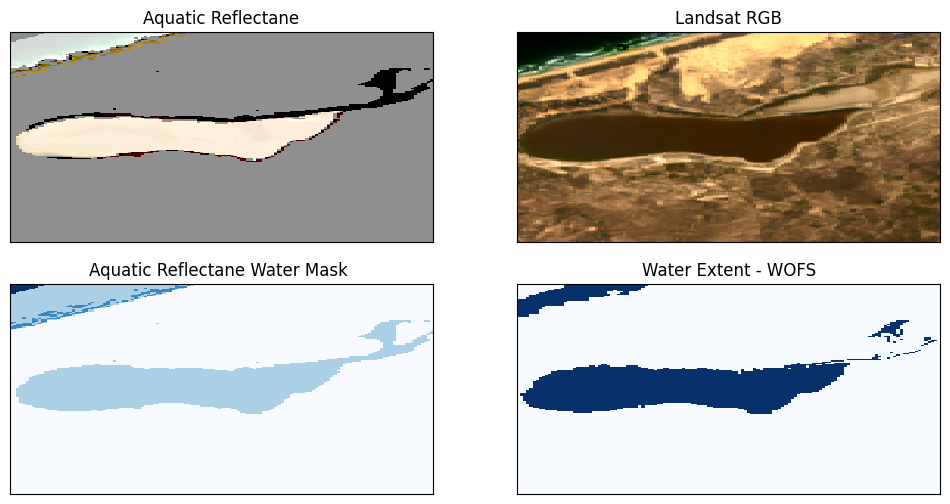

In [9]:
# Plot the aquatic, landsat and water extent
fig, ax = plt.subplots(2, 2, figsize=(12, 6))

#plot the aquatic true colour image
rgb(ds_aq, ax=ax[0, 0])

#plot the true colour image
rgb(ds_ls, ax=ax[0, 1])

#plot the aquatic water mask 
ds_aq.water.squeeze().plot.imshow(ax=ax[1, 0], cmap="Blues", add_colorbar=False)

#plot the water extent from WOfS
water_extent.plot.imshow(ax=ax[1, 1], cmap="Blues", add_colorbar=False)

# Titles
ax[0, 0].set_title("Aquatic Reflectane"), ax[0, 0].xaxis.set_visible(False), ax[0, 0].yaxis.set_visible(False)
ax[0,  1].set_title("Landsat RGB"), ax[0, 1].xaxis.set_visible(False), ax[0, 1].yaxis.set_visible(False);
ax[1, 0].set_title("Aquatic Reflectane Water Mask "), ax[1, 0].xaxis.set_visible(False), ax[1, 0].yaxis.set_visible(False);
ax[1, 1].set_title("Water Extent - WOFS"), ax[1, 1].xaxis.set_visible(False), ax[1, 1].yaxis.set_visible(False);

##### Timeseries

In [10]:
time_range = ('2020','2021')

##### Load Aquatic Reflectance 

In [11]:
# load data
ds_aq_range = dc.load(product="landsat_c2l2_ar",
             measurements=['water'],
             like=ds_aq.geobox,
             time=time_range,
             group_by="solar_day",
            )

ds_range_extent = (ds_aq_range.water == 1)

##### Load Landsat 8 or 9  

In [12]:
ds_ls_range = dc.load(product="ls8_sr",
              measurements=['swir_1', 'green'],
             like=ds_aq.geobox,
              time=time_range,
              group_by="solar_day"
             )
ds_ls_range = calculate_indices(ds_ls_range, index="MNDWI", satellite_mission="ls")

##### Load WOfS

In [13]:
# load data
ds_wofs_range = dc.load(product="wofs_ls",
             time=time_range,
             group_by="solar_day",
                  like=ds_aq.geobox,
             ).water

water_extent = (ds_wofs_range == 128)

##### Calculate the annual area for pixel

In [14]:
pixel_length = ds_aq.geobox.resolution[1]  # in metres
m_per_km = 1000  # conversion from metres to kilometres
area_per_pixel = pixel_length**2 / m_per_km**2

#### Calculate the area Aquatic Reflectance, MNDWI AND WOfS

In [15]:
ds_aq_water_area = ds_range_extent.sum(dim=['x', 'y']) * area_per_pixel

In [16]:
water = ds_ls_range.MNDWI.where(ds_ls_range.MNDWI > 0, np.nan)
area_ds = water.where(np.isnan(water), 1)
ds_ls_range_area = area_ds.sum(dim=['x', 'y']) * area_per_pixel

In [17]:
#calculate area
ds_valid_water_area = water_extent.sum(dim=['x', 'y']) * area_per_pixel

#### Plot seasonal time series from the 

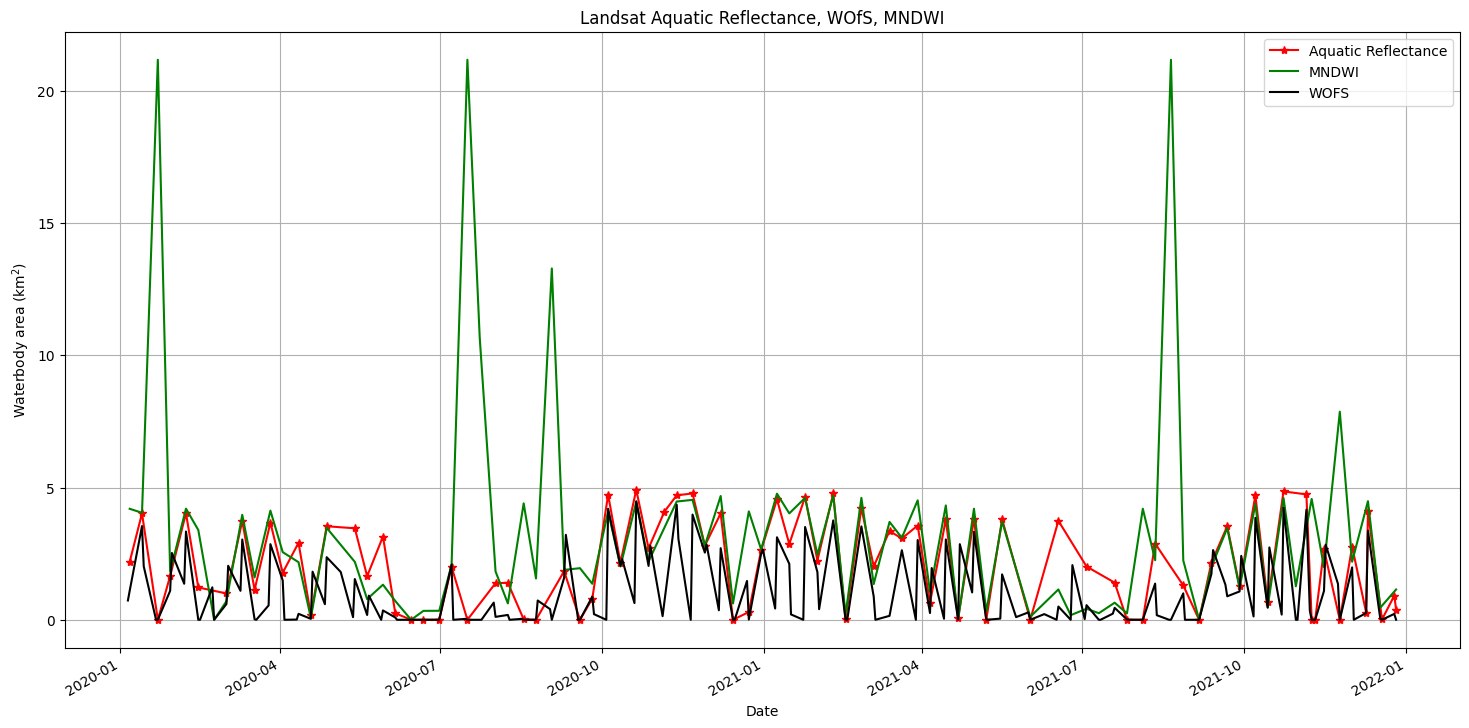

In [18]:
plt.figure(figsize=(18, 8))
ds_aq_water_area.plot(marker='*', color='red', label='Aquatic Reflectance')
ds_ls_range_area.plot(marker='', color='green', label='MNDWI')
ds_valid_water_area.plot(marker='', color='black', label='WOFS')
plt.ylabel('Waterbody area (km$^2$)')
plt.xlabel('Date')
plt.grid()
plt.title('Landsat Aquatic Reflectance, WOfS, MNDWI')
plt.legend(loc="upper right")
plt.show()

#### Visualise the a particular image from the timeseries

In [19]:
timestep = 3
time_value = ds_range_extent.isel(time=timestep).time.values

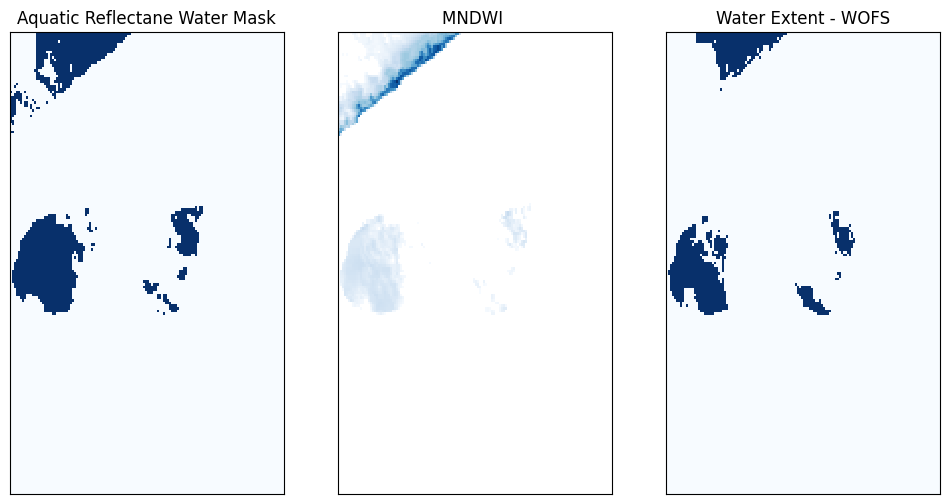

In [20]:
# Plot the aquatic, landsat and water extent
fig, ax = plt.subplots(1, 3, figsize=(12, 6))

#plot the aquatic water mask 
ds_range_extent.sel(time=time_value).squeeze().plot.imshow(ax=ax[0], cmap="Blues", add_colorbar=False)

#plot the water extent from WOfS
water.sel(time=time_value).plot.imshow(ax=ax[1], cmap="Blues", add_colorbar=False)

#plot the water extent from WOfS
water_extent.sel(time=time_value).plot.imshow(ax=ax[2], cmap="Blues", add_colorbar=False)

# Titles
ax[0].set_title("Aquatic Reflectane Water Mask"), ax[0].xaxis.set_visible(False), ax[0].yaxis.set_visible(False)
ax[1].set_title("MNDWI "), ax[1].xaxis.set_visible(False), ax[1].yaxis.set_visible(False);
ax[2].set_title("Water Extent - WOFS"), ax[2].xaxis.set_visible(False), ax[2].yaxis.set_visible(False);

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Compatible datacube version:** 

In [21]:
print(datacube.__version__)

1.8.15


**Last Tested:**

In [22]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')

'2024-02-14'